In [1]:
import time

from pathlib import Path

import plotly.express as px
import plotly.graph_objects as go
import polars as pl

from plotly.subplots import make_subplots
from result import Result

from raft.io import read_file

from raft.utils.log import logger

from raft.tasks.message_parsing.data_types import MessageParseData

In [2]:
from raft.services.sirius_messages import (
    ImageCaptureMessage,
    
    SeabirdCTDMessage,
    AanderaaCTDMessage,
    EcopuckMessage,
    
    ParosciPressureMessage,
    TeledyneDVLMessage,
    LQModemMessage,
    EvologicsModemMessage,

    BatteryMessage,
    ThrusterMessage,
)

from raft.services.sirius_messages import (
    parse_message_header,
    parse_image_message,

    parse_seabird_ctd_message,
    parse_aanderaa_ctd_message,
    parse_ecopuck_message,

    parse_parosci_pressure_message,
    parse_teledyne_dvl_message,
    parse_lq_modem_message,
    parse_evologics_modem_message,

    parse_battery_message,
    parse_thruster_message,
)

### Load data

In [3]:
paths: dict = dict()

paths["datadir"] = Path("/media/martin/pcie_01/acfr_revisits_processed/acfr_merged_message_files")
paths["messages"] = paths["datadir"] / Path("qdc5ghs3_20210315_230947_messages.txt")

lines: list[str] = read_file(paths["messages"]).unwrap()


TOPIC_TO_PARSER: dict = {
    "EVOLOGICS_FIX": parse_evologics_modem_message,
}


def parse_messages(lines: list[str], parsers: dict) -> dict:
    """TODO"""
    parsed_messages: dict[type, object] = dict()
    
    for line in lines:
        header = parse_message_header(line).unwrap()

        if not header.topic in parsers:
            continue

        parsed: object = parsers[header.topic](line).unwrap()
        
        if not type(parsed) in parsed_messages:
            parsed_messages[type(parsed)] = list()
        else:
            parsed_messages[type(parsed)].append(parsed)
            
    return parsed_messages

parsed_messages: dict[type, list[object]] = parse_messages(lines, TOPIC_TO_PARSER)

for message_type, messages in parsed_messages.items():
    logger.info(f"{message_type}: {len(messages)}")

2024-06-07 15:22:34.946 | INFO     | __main__:<module>:36 - <class 'raft.services.sirius_messages.data_types.EvologicsModemMessage'>: 75


### Define plot functions

In [20]:
def plot_evologics_scatter(data: pl.DataFrame) -> None:
    """TODO"""
    fig = px.scatter_mapbox(
        data,
        lat="target_latitude",
        lon="target_longitude",
        color="timestamp",
        size_max=15,
        zoom=16,
        height=600,
        hover_data={"target_depth"},
    )
    
    fig.update_layout(height=800, width=1000, mapbox_style="open-street-map")
    return fig

### Format LQ Modem messages

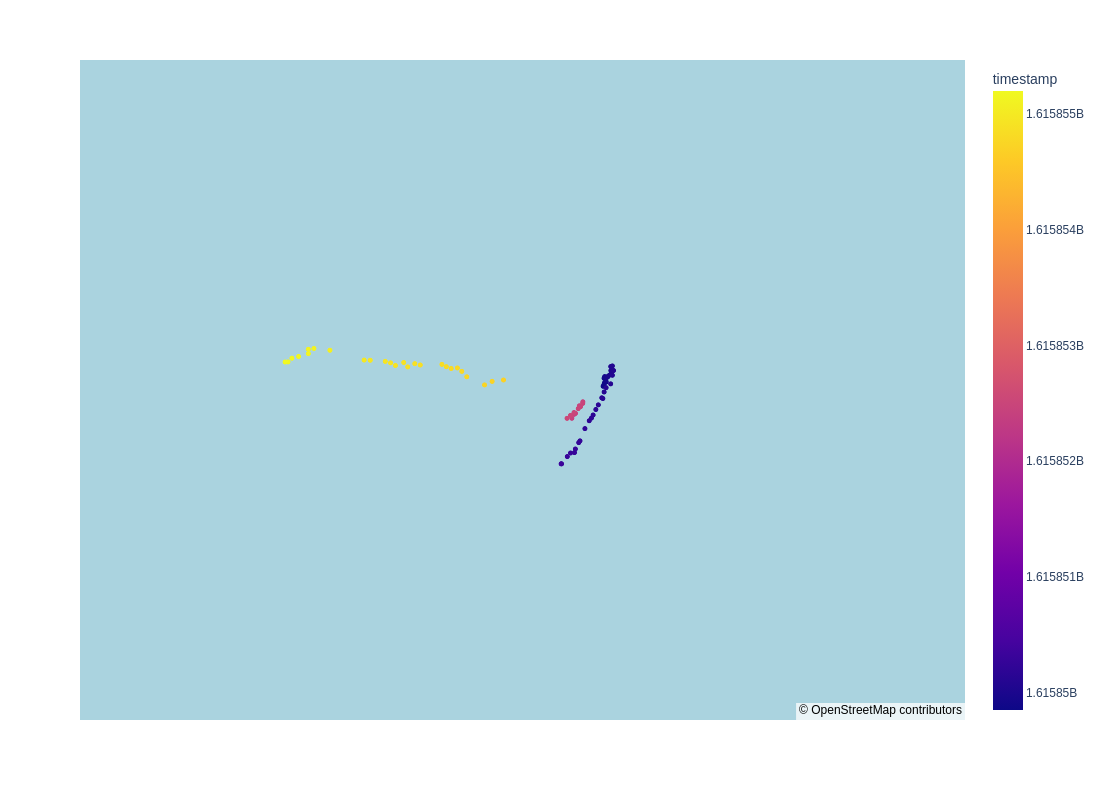

In [21]:
data: dict = dict()

if TeledyneDVLMessage in parsed_messages:
    data["dvl"]: pl.DataFrame = pl.DataFrame([
        {
            "topic": message.header.topic,
            "timestamp": message.header.timestamp,
            
            "altitude": message.body.altitude,
            
            "range_01": message.body.range_01,
            "range_02": message.body.range_02,
            "range_03": message.body.range_03,
            "range_04": message.body.range_04,
        
            "heading": message.body.heading,
            "pitch": message.body.pitch,
            "roll": message.body.roll,
        
            "velocity_x": message.body.velocity_x,
            "velocity_y": message.body.velocity_y,
            "velocity_z": message.body.velocity_z,
        
            "dmg_x": message.body.dmg_x,
            "dmg_y": message.body.dmg_y,
            "dmg_z": message.body.dmg_z,
        
            "course_over_ground": message.body.course_over_ground,
            "speed_over_ground": message.body.speed_over_ground,
            "true_heading": message.body.true_heading,
        
            "gimbal_pitch": message.body.gimbal_pitch,
            "sound_velocity": message.body.sound_velocity,
        
            "bottom_track_status": message.body.bottom_track_status,
    
        } for message in parsed_messages[TeledyneDVLMessage]
    ])

if EvologicsModemMessage in parsed_messages:
    data["evologics"]: pl.DataFrame = pl.DataFrame([
        {
            "topic": message.header.topic,
            "timestamp": message.header.timestamp,
            
            "target_latitude": message.body.target_latitude,
            "target_longitude": message.body.target_longitude,
            "target_depth": message.body.target_depth,
            
            "ship_latitude": message.body.ship_latitude,
            "ship_longitude": message.body.ship_longitude,
    
            "ship_heading": message.body.ship_heading,
            "ship_pitch": message.body.ship_pitch,
            "ship_roll": message.body.ship_roll,
            
        } for message in parsed_messages[EvologicsModemMessage]
    ])

figs: dict = dict()
figs["usbl_scatter"] = plot_evologics_scatter(data["evologics"])
figs["usbl_scatter"].show()